## Personality Trait Cluster Analysis

The most prominent model of personality in psychology is the Big Five Model which is comprised of five fundamental personality dimensions on which people differ:
1. <b>Extraversion</b>: characterized by traits like sociability and assertiveness
2. <b>Agreeableness</b>: characterized by traits like compassion and respectfulness
3. <b>Conscientiousness</b>: characterized by traits like productiveness and responsibility
4. <b>Neuroticism</b>: characterized by traits like anxiety and emotional volatility
5. <b>Openness to Experience</b>: characterized by traits like  intellectual curiosity and creativity

Using data from three distinct samples (<i>N</i>=800), the purpose of this project is to cluster individuals across these five personality dimensions as a way of identifying latent personality profiles. To this end, I used PCA to reduce the five dimensions to three principal components for data visualization purposes and then clustered these principal components using k-means clustering and Gaussian Mixture Models. Cluster solutions were determined using silhouette scores for k-means clustering and BIC scores for GMMs. 

### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
import plotly.io as pio  
pio.renderers.default='notebook' 

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

from cluster_analysis_functions import (
    correlation_heatmap,
    get_pca_explained_variance,
    get_pca_component_values,
    dual_axis_lineplot,
    kmean_gridsearch,
    gmm_gridsearch,
    cluster_animation
)

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

### Retrieving and Examining Data

The dataset includes the Big Five personality trait dimension scores for 800 people, which was collected and integrated across three samples. 

All preprocessing (e.g., feature recoding, handling missing values) has already been completed and can be found in <b>"Data Cleaning and Preprocessing.ipynb."</b>

In [2]:
df = pd.read_csv("datasets/personality_trait_data.csv", index_col=["study", "subject_id"])

In [3]:
df.head(3)

Extraversion  Agreeableness  Conscientiousness  \
study   subject_id                                                   
Study 1 0               2.666667       3.833333           2.666667   
        1               3.333333       3.166667           3.500000   
        2               4.166667       2.833333           2.500000   

                    Neuroticism  Openness  
study   subject_id                         
Study 1 0              2.333333  3.166667  
        1              2.833333  4.166667  
        2              3.833333  3.833333

In [4]:
df.describe()

Extraversion  Agreeableness  Conscientiousness  Neuroticism    Openness
count    800.000000     800.000000         800.000000   800.000000  800.000000
mean       3.063333       3.631042           3.510833     2.767917    3.580208
std        0.746299       0.674661           0.715091     0.842044    0.668898
min        1.000000       1.333333           1.166667     1.000000    1.000000
25%        2.666667       3.166667           3.000000     2.166667    3.000000
50%        3.000000       3.666667           3.500000     2.833333    3.500000
75%        3.500000       4.166667           4.000000     3.166667    4.000000
max        5.000000       5.000000           5.000000     5.000000    5.000000

### Examining Relationships between Trait-level Scores

As an exploratory data analysis, I will examine relationships between the Big Five trait scores.

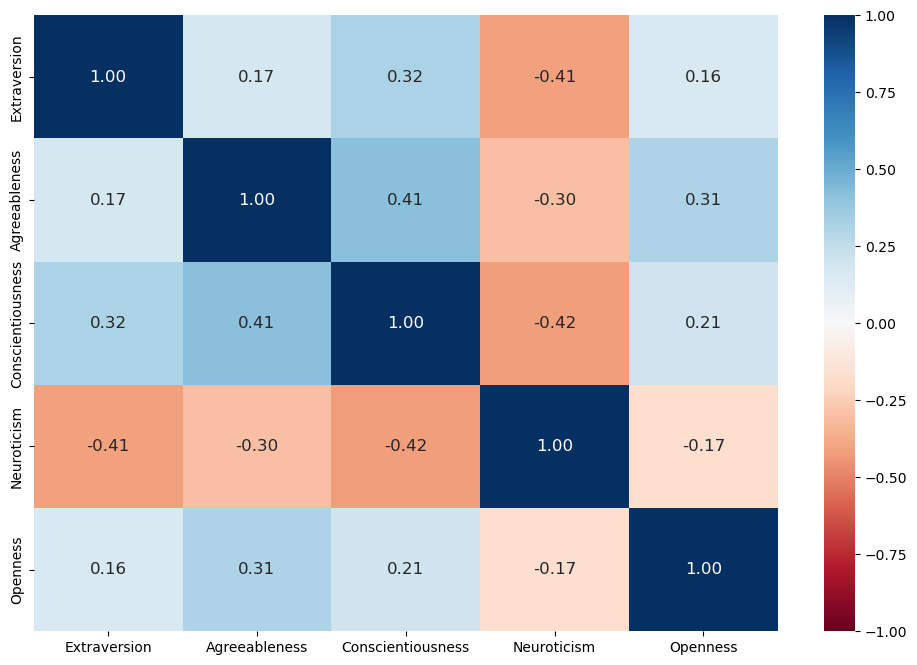

In [5]:
correlation_heatmap(df, vmin=-1.00, vmax=1.00, annot=True, fmt=".2f",
                    annot_kws={"size": 12}, cmap="RdBu")

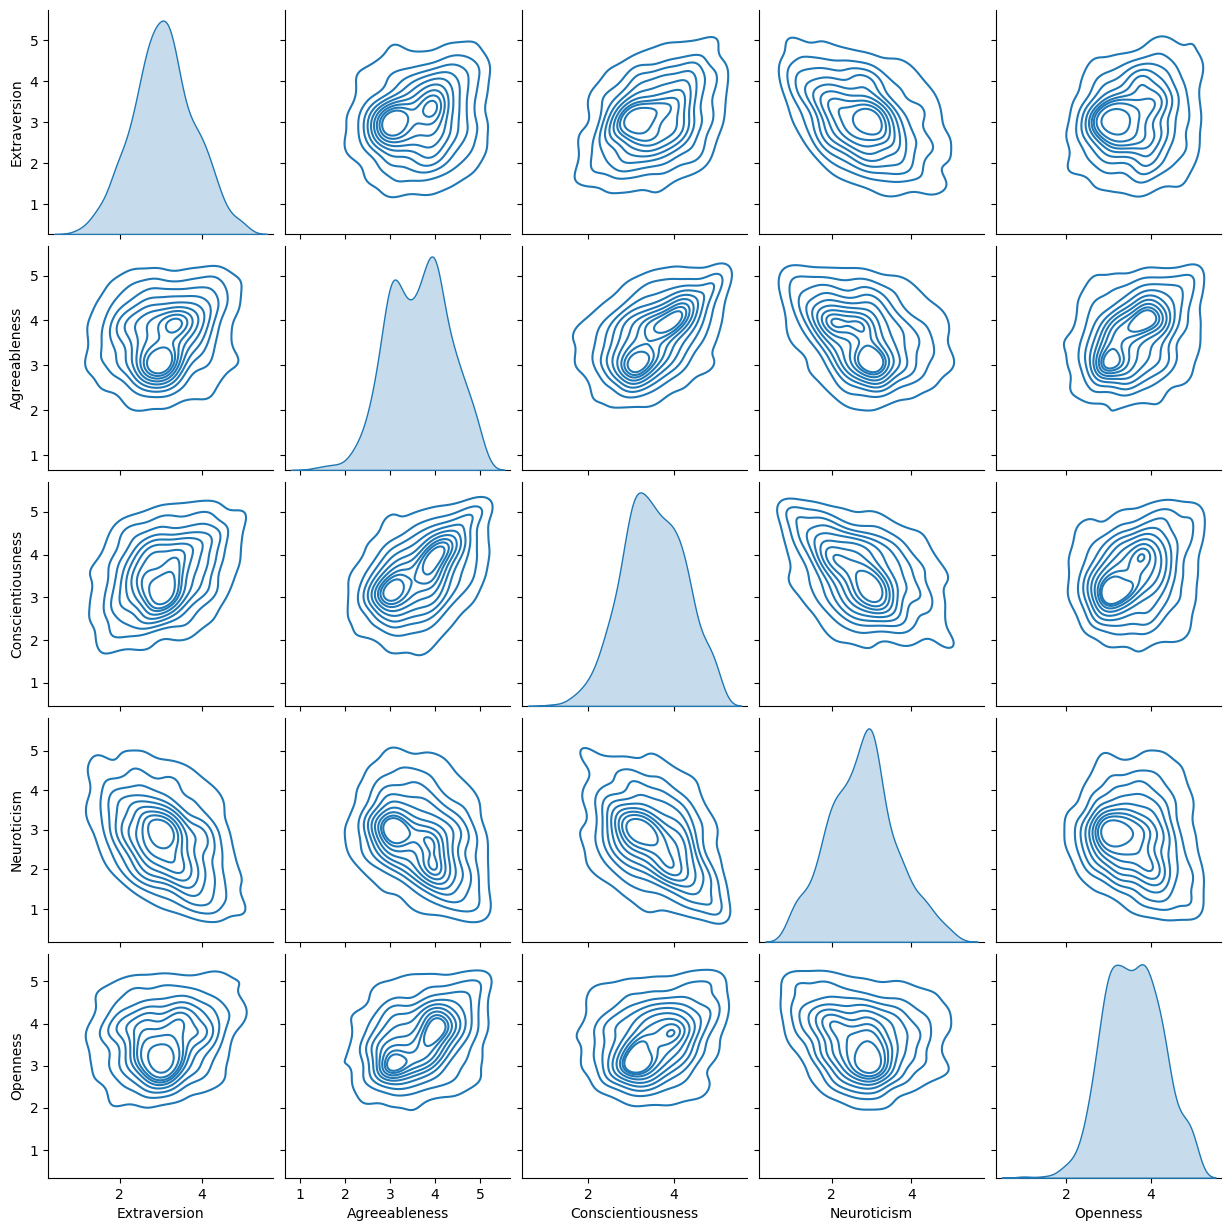

In [6]:
sns.pairplot(df, kind="kde");

Neuroticism scores are negatively related to all other trait scores (<b>-.17 < <i>r</i>s < -.42</b>).

Among the other four traits, conscientiousness is positively related to extraversion (<b><i>r</i> = .32</b>), agreeableness (<b><i>r</i> = .41</b>), and openness (<b><i>r</i> = .21</b>), and agreeableness is positively related to openness (<b><i>r</i> = .31</b>). 

All other correlations were comparatively weak (<b><i>r</i> < .20</b>).

### Performing Dimensionality Reduction on Trait-level Scores using PCA

For the purposes of visualizing personality clusters, I will use PCA to reduce the Big Five personality dimensions to a 2- or 3-dimensional feature space while still attempting to recover the majority of the total variance in the data.

To this end, I will standardize the data and recover all five principal components to examine the variance explained by each component.

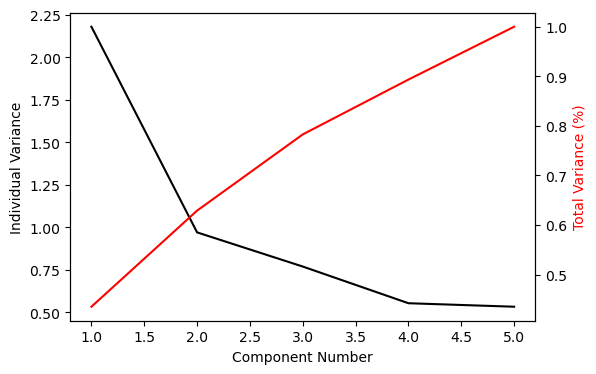

In [7]:
df_st = StandardScaler().set_output(transform="pandas").fit_transform(df)

pca_est = PCA(n_components=df_st.shape[1], random_state=0).fit(df_st)

pca_exp_var = get_pca_explained_variance(pca_est)

dual_axis_lineplot(
    df=pca_exp_var,
    y1="Individual Variance",
    y2="Total Variance (%)",
    figsize=(6, 4),
    color=["k", "r"],
    legend=False
)

Reducing the Big Five trait dimensions to two components would recover ~60% of variance, while recovering three components would recover ~80% of variance. As a consequence, I will reduce the Big Five traits to three dimensions for data visualization purposes in the cluster analyses.

Before reducing the dimensionality of the data, I will examine how each of the original big five features load onto the three components.

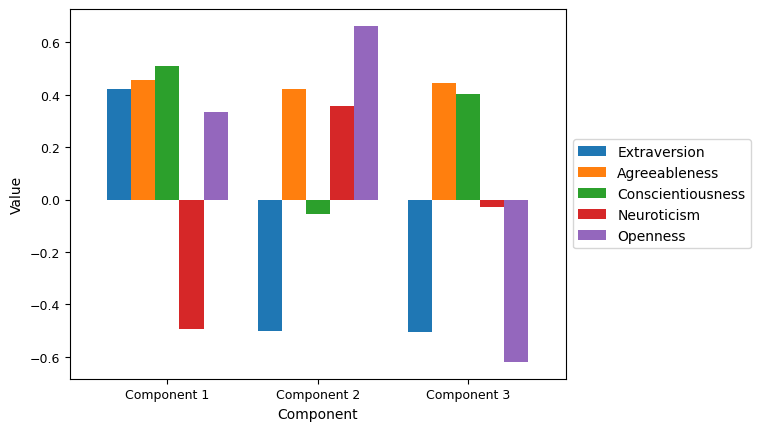

In [8]:
pca_comp_vals = get_pca_component_values(pca_est)

pca_comp_ax = pca_comp_vals[:3].plot(
    kind="bar",
    xlabel="Component",
    ylabel="Value",
    rot=0,
    fontsize=9,
    width=.80
)

pca_comp_ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

The first component may reflect a social desirability bias, because higher scores on extraversion, agreeableness, conscientiousness, and openness and lower scores on neuroticism are perceived as socially desirable.

The second component is characterized by low extraversion and high agreeableness, neuroticism and openness.

The third component may reflect conventionality because this dimension is characterized by high agreeableness and conscientiousness (e.g., compassion, respectfulness, productiveness, respectfulness) but low extraversion and openness to experience (e.g., low sociability, low intellectual curiosity).

### Transforming and Visualizing Trait Scores in 3 Dimensions

In [9]:
pca_est.set_params(n_components=3).set_output(transform="pandas")

df_pca = pca_est.fit_transform(df_st)

In [10]:
px.scatter_3d(
    data_frame=df_pca,
    x="pca0",
    y="pca1",
    z="pca2",
    size_max=10,
    opacity=.10,
    title="Interactive 3D Scatterplot of Trait Principal Components"
)

### K-means Clustering

I will now perform k-means clustering for the three principal components across a range of k values. Before doing so, I will first standardize the newly obtained principal components so they have equal weighting in the analyses. 

In [11]:
df_pca_st = StandardScaler().set_output(transform="pandas").fit_transform(df_pca)

df_pca_st.agg(["mean", "std"]).round(2)

pca0  pca1  pca2
mean   0.0   0.0   0.0
std    1.0   1.0   1.0

In [12]:
km_ests, km_traits_df = kmean_gridsearch(
    df=df_pca_st,
    ks=range(2, 31),
    n_init=50,
    random_state=0
)

Next, I will plot the inertia and silhouette scores of the cluster solutions by k value.

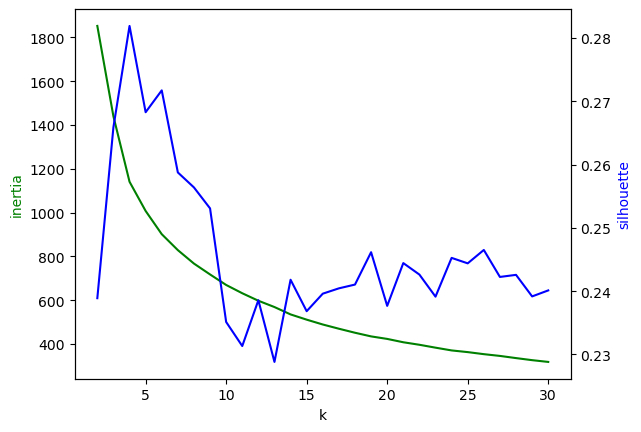

In [13]:
dual_axis_lineplot(
    df=km_traits_df,
    y1="inertia",
    y2="silhouette",
    color=["g", "b"],
    legend=False
)

While there is not a clear elbow in inertia scores over k, there is a clear maximum in silhouette score for the 4-cluster solution. 

To gain further insight into the cluster solutions across values of k, I will plot an interactive 3D scatterplot by k.

In [14]:
cluster_animation(
    df=df_pca_st,
    cluster_estimators=km_ests,
    cluster_nums=range(2, 31),
    opacity=.20,
    title="Interactive 3D Scatterplot of K-means Trait Clusters"
)

Given that the 4-cluster solution had the best silhouette score, I will cluster people according to this solution and examine mean standardized personality trait scores. 

0    269
1    150
2    200
3    181
dtype: int64

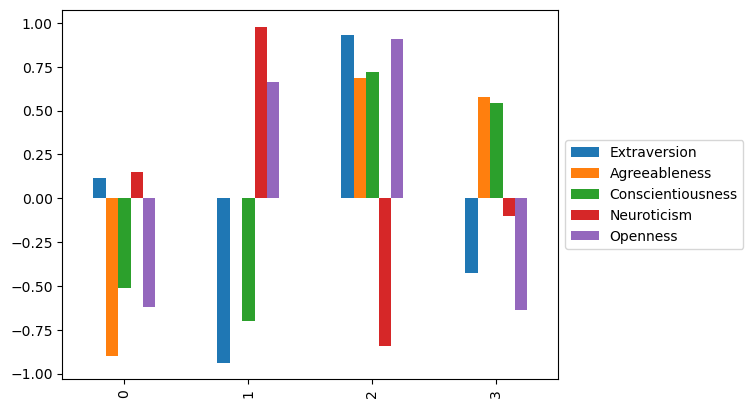

In [15]:
best_km_est = km_ests[km_traits_df["silhouette"].argmax()]

km_preds = best_km_est.predict(df_pca_st)

display(df_st.groupby(km_preds).size())

km_clusters_ax = df_st.groupby(km_preds).mean().plot(kind="bar")
km_clusters_ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

The <b>first cluster</b> is characterized by low agreeableness, conscientiousness, and openness scores. This pattern suggests that these people are less compassionate, responsible, and intellectual curious as compared to others. Interestingly, low agreeableness and conscientiousness is a personality profile consistent with antisocial traits (e.g., psychopathy).

The <b>second cluster</b> shows very low extraversion and conscientiousness scores, but high neuroticism and openness scores. This pattern suggests that these people are less sociable and productive and are more anxious, creative, and intellectually curious as compared to others. 

The <b>third cluster</b> shows high extraversion, agreeableness, conscientiousness, and openness and low neuroticism scores. This personality profile is consistent with the socially desirable personality profile as mentioned in the PCA analyses.

Finally, the <b>fourth cluster</b> shows high agreeableness and conscientiousness and low extraversion and openness to experience. This pattern is consistent with the conventional personality profile mentioned in the PCA analyses.

### Gaussian Mixture Models

Next, I will perform cluster analyses using Gaussian Mixtures Models (GMMs). While these models are more computationally expensive, they offer greater flexibility than k-means in that clusters can (1) differ in size and (2) have an elliptical (rather than globular) shape.

In [16]:
gmm_ests, gmm_traits_df = gmm_gridsearch(
    df=df_pca_st,
    cluster_nums=range(2, 31),
    n_init=50,
    random_state=0
)

Next, I will plot the AIC and BIC scores by number of clusters.

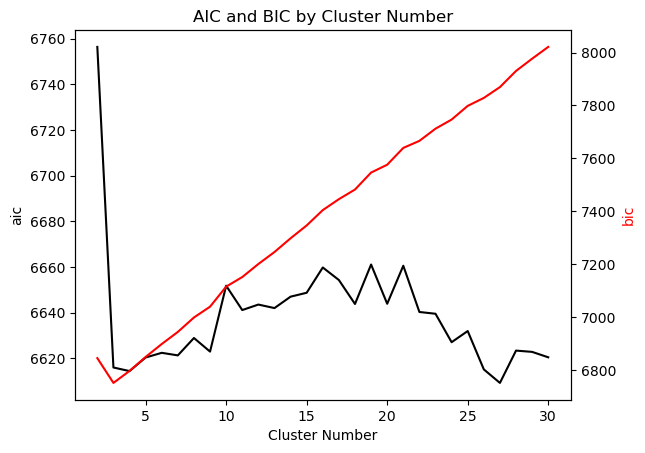

In [17]:
dual_axis_lineplot(
    df=gmm_traits_df,
    y1="aic",
    y2="bic",
    color=["k", "r"],
    legend=False,
    title="AIC and BIC by Cluster Number"
)

BIC scores show a very clear minimum at the 3-cluster solution. AIC decreases until the 3-cluster solution and remains relatively level until a minimum at the 27-cluster solution.

To gain further insight into the cluster solutions across solutions, I will plot an interactive 3D scatterplot by cluster number.

In [18]:
cluster_animation(
    df=df_pca_st,
    cluster_estimators=gmm_ests,
    cluster_nums=range(2, 31),
    opacity=.20,
    title="Interactive 3D Scatterplot of GMM Trait Clusters"
)

Given that the 27-cluster solution suggested by AIC scores is not a feasible clustering strategy, I will cluster people according to the 3-cluster solution, which resulted in the minimal BIC score.  

0    340
1    137
2    323
dtype: int64

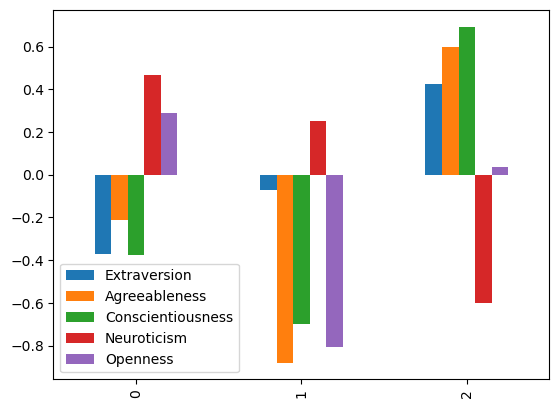

In [19]:
best_gmm_est = gmm_ests[gmm_traits_df["bic"].argmin()]

gmm_preds = best_gmm_est.predict(df_pca_st)

display(df_st.groupby(gmm_preds).size())

df_st.groupby(gmm_preds).mean().plot(kind="bar");

The <b>first cluster</b> seems like a less extreme version of the second cluster in the k-means solution, again showing relatively low extraversion and conscientiousness but high neuroticism and openness.

The <b>second cluster</b> seems like a more extreme version of the first cluster in the k-means solution, again showing relatively low agreeableness, conscientiousness, and openness and higher neuroticism. This pattern may also be suggestive of some antisocial tendencies (e.g., psychopathy).

Finally, the <b>third cluster</b> seems quite similar to the third cluster in the k-means solution, again showing high extraversion, agreeableness, and conscientiousness and low neuroticism. This pattern is consistent with a socially desirable set of personality traits.

### Summary

Across cluster solutions from both k-means and GMMs:
1. <b>Socially desirable cluster</b>: A cluster of people with traits considered socially desirable including higher extraversion, agreeableness, and conscientiousness and lower neuroticism. It is not clear the extent to which these people actually possess these traits or whether this personality profile reflects a socially desirable response bias.

2. <b>Antisocial cluster</b>: A cluster of people with a personality profile that is at least partially consistent with antisocial profiles (e.g., psychopathy), notably characterized by low agreeableness (e.g., low compassion, trust) and low conscientiousness (e.g., impulsivity).

3. <b>Anxious Introvert Cluster</b>: A cluster of people who are introverted and neurotic (e.g., anxious, depressed) but open to experience (e.g., creative, intellectually curious). 

In addition, the k-means analyses suggested a <b>fourth cluster</b> which could be categorized as a <b>conventional cluster</b>, showing high agreeableness and conscientiousness (e.g., polite, kind, organized, reliable) but low in extraversion and openness to experience (e.g., not sociable, not intellectually curious).

